사용한 방법 & 알고리즘: Melspectrogram feature extraction + DNN 

# 필요한 모듈 import

In [1]:
#pip install librosa

In [2]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
from scipy.io import wavfile
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

import keras
from keras import models
from keras import layers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# GPU 확인
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-12-05 10:39:01.432977: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11238712375333553666
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5373427712
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 12414138086504958613
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:05.0, compute capability: 7.0"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 158859264
 locality {
   bus_id: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 10103656559517430043
 physical_device_desc: "device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0"
 xla_global_id: 2144165316]

# 하이퍼파라미터 설정 및 시드 고정

In [4]:
# 하이퍼파라미터 설정

CFG = {
    'SR':16000, # Sampling Rate(샘플링 비율)
    'N_melspectrogram':16, # Melspectrogram 벡터를 추출할 개수 
    'SEED':41
}

In [5]:
# 시드 고정
# 'SEED' 사용

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
seed_everything(CFG['SEED'])

# 데이터 로드

csv 데이터 로드

In [6]:
# base path 지정 및 데이터 로드

base_path = './data/'
train_df = pd.read_csv( base_path + 'train_data.csv')
test_df = pd.read_csv( base_path + 'test_data.csv')

In [7]:
train_df

,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19
0,1,24,female,0,1,0
1,2,51,male,0,0,0
2,3,22,male,0,0,0
3,4,29,female,1,0,0
4,5,23,male,0,0,0
...,...,...,...,...,...,...
3800,3801,53,male,0,0,0
3801,3802,25,male,0,0,0
3802,3803,26,female,0,0,0
3803,3804,27,female,0,0,0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3805 entries, 0 to 3804
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     3805 non-null   int64 
 1   age                    3805 non-null   int64 
 2   gender                 3805 non-null   object
 3   respiratory_condition  3805 non-null   int64 
 4   fever_or_muscle_pain   3805 non-null   int64 
 5   covid19                3805 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 178.5+ KB


In [9]:
test_df

,id,age,gender,respiratory_condition,fever_or_muscle_pain
0,3806,48,female,1,0
1,3807,24,female,0,0
2,3808,29,male,0,0
3,3809,39,female,0,0
4,3810,34,male,0,0
...,...,...,...,...,...
5727,9533,43,male,0,0
5728,9534,48,female,0,1
5729,9535,44,female,0,0
5730,9536,25,female,0,0


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5732 entries, 0 to 5731
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     5732 non-null   int64 
 1   age                    5732 non-null   int64 
 2   gender                 5732 non-null   object
 3   respiratory_condition  5732 non-null   int64 
 4   fever_or_muscle_pain   5732 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 224.0+ KB


In [11]:
train_df['covid19'].value_counts()

0    3499
1     306
Name: covid19, dtype: int64

In [12]:
train_df[train_df['covid19']==1]

,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19
6,7,33,male,0,0,1
14,15,30,male,0,0,1
15,16,24,female,0,0,1
22,23,31,female,1,0,1
26,27,12,female,0,1,1
...,...,...,...,...,...,...
3756,3757,41,male,0,0,1
3758,3759,13,other,1,0,1
3772,3773,27,male,1,1,1
3779,3780,34,male,0,0,1


In [13]:
train_df[train_df['covid19']==0]

,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19
0,1,24,female,0,1,0
1,2,51,male,0,0,0
2,3,22,male,0,0,0
3,4,29,female,1,0,0
4,5,23,male,0,0,0
...,...,...,...,...,...,...
3800,3801,53,male,0,0,0
3801,3802,25,male,0,0,0
3802,3803,26,female,0,0,0
3803,3804,27,female,0,0,0


위의 age(나이), gender(성별)은 물론 respiratory_condition(호흡기 질환 여부)과 fever_or_muscle_pain(발열 혹은 근육통 증상 여부)의 유무만으로는 covid19(코로나19 음성/양성 여부)를 예측하기 힘들다고 볼 수 있음  
- respiratory_condition=0, fever_or_muscle_pain=0 : idx 1(음성)/6(양성)
- respiratory_condition=1, fever_or_muscle_pain=0 : idx 3(음성)/22(양성)  
- respiratory_condition=0, fever_or_muscle_pain=1 : idx 0(음성)/26(양성)
- respiratory_condition=1, fever_or_muscle_pain=1 : idx 3804(음성)/3772(양성)  

따라서 EDA 과정에서 csv 파일과 함께 주어진 wav 데이터로부터 주요 특징을 뽑아내는 시도를 하려고 함

# EDA

위의 train,test csv 파일에 있는 column말고 음향 데이터에서 특징을 뽑아내어 column으로 추가하기 위해 주어진 음향 데이터의 특징을 시각화하려고 함  

## 오디오 파일 이해

### 기본값 확인

In [14]:
# 음성.wav file의 sampling rate 확인
fs_0, data_0 = wavfile.read('./data/train/00001.wav')

print(fs_0)
print(data_0)

48000
[    0     0     0 ...  2872 -4016 -6139]


In [15]:
# 양성.wav file의 sampling rate 확인
fs_1, data_1 = wavfile.read('./data/train/00007.wav')

print(fs_1)
print(data_1)

48000
[     0      0      0 ... 521448 538902 427643]


sampling rate를 원본 48000Hz -> 16000Hz로 변경하여 분석  
16000Hz로 변경하는 이유: 대회 baseline sampling rate도 16000Hz였고, 여러 자료들을 검색해보니 분석하기 좋은 Hz가 16000Hz인 것 같음  

Sampling rate: "1초당 샘플의 빈도수". sampling rate가 너무 크면 모델 학습이 어려운 것으로 보임

### 오디오 파일 로드  
train 중 음성 판정을 받은 데이터(00001.wav)와 양성 판정을 받은 데이터(00007.wav)를 각 단계마다 비교해가며 분석

**음성(0)**

In [16]:
y_0, sr_0 = librosa.load('./data/train/00001.wav', sr=16000) # 샘플링 비율 설정

print(y_0)
print(len(y_0))
print('Sampling rate (Hz): %d' %sr_0)
print('Audio length (seconds): %.2f' % (len(y_0) / sr_0))

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.8238366e-06
  1.4052406e-06 -1.2726812e-06]
78720
Sampling rate (Hz): 16000
Audio length (seconds): 4.92


**양성(1)**

In [17]:
y_1, sr_1 = librosa.load('./data/train/00007.wav', sr=16000) # 샘플링 비율 설정

print(y_1)
print(len(y_1))
print('Sampling rate (Hz): %d' %sr_1)
print('Audio length (seconds): %.2f' % (len(y_1) / sr_1))

[0.         0.         0.         ... 0.00043462 0.00025354 0.00023495]
156480
Sampling rate (Hz): 16000
Audio length (seconds): 9.78


### 2D 음파 그래프

**음성(0)**

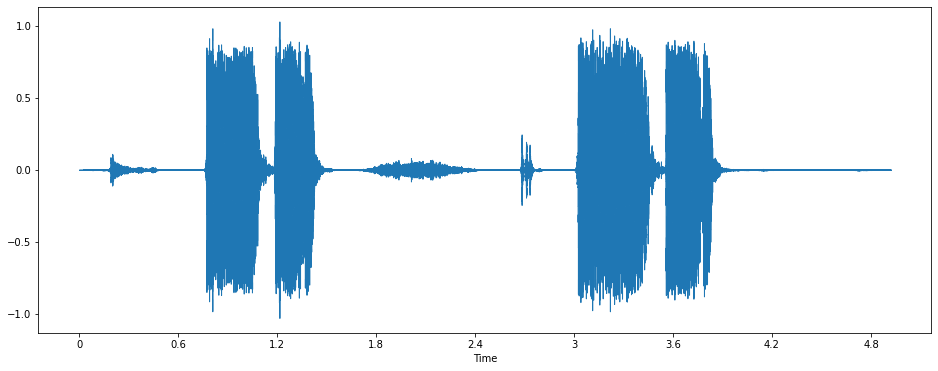

In [18]:
plt.figure(figsize=(16,6))
librosa.display.waveshow(y=y_0, sr=sr_0)
plt.show()

**양성(1)**

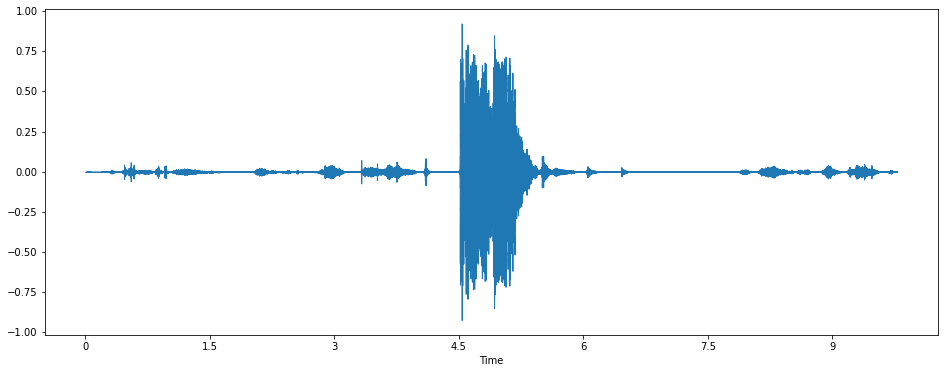

In [19]:
plt.figure(figsize=(16,6))
librosa.display.waveshow(y=y_1, sr=sr_1)
plt.show()

### 푸리에 변환(Fourier Transform)  
: 음성 신호에 푸리에 변환을 적용하면 각 진동수 성분이 그 음성에 얼마나 들어있는지 알 수 있음. 쉽게 설명하면 **음성 신호에 저음이 얼마나 있고, 고음이 얼마나 있는지를 정량적으로 구할 수 있음**  
즉 시간(time)을 기준으로 봤던 것을 진동수(frequency)를 기준으로 본 그래프(다음 링크의 그림 참조: https://i0.wp.com/play.fallows.ca/wp/wp-content/uploads/sites/4/2017/01/Signal-Analysis.jpg )

<주요 옵션(parameter)>
- win_length: 음성을 작은 조각으로 자를 때 **작은 조각의 크기**를 의미, `16000Hz 음성에서는 400에 해당하는 값`
- n_fft: win_length의 크기로 잘린 음성의 작은 조각은 **0으로 padding되어서 n_fft로 크기가 맞춰짐**, 이렇게 padding된 조각에 푸리에 변환이 적용됨, 따라서 n_fft는 win_length보다 크거나 같아야 하고 일반적으로 속도를 위해서 2의 거듭제곱 수로 값을 설정함. `16000Hz 음성에서는 400으로 하여 주로 win_length와 같게 맞춰줌`  
- hop_length: 음성을 작은 조각으로 자를 때 **자르는 간격**을 의미, `16000Hz 음성에서는 160에 해당하는 값`  


**음성(0)**

(201, 493)


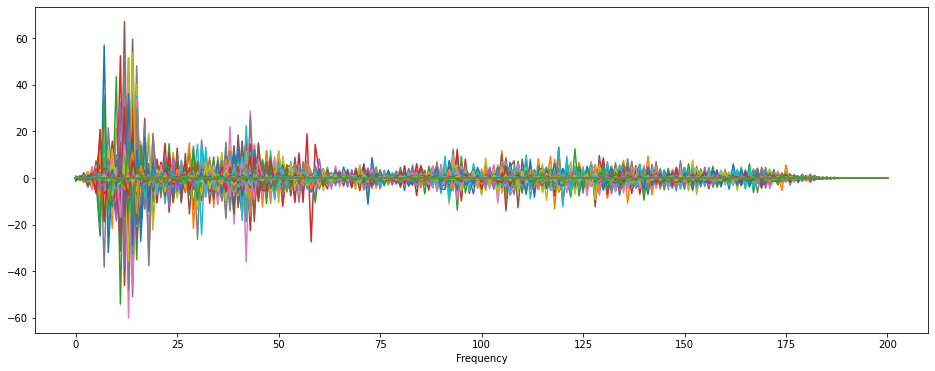

In [22]:
ft_0 = librosa.stft(y_0, n_fft=400, hop_length=160)# n_fft, hop_length 변경

print(ft_0.shape)

plt.figure(figsize=(16,6))
plt.plot(ft_0)
plt.xlabel("Frequency")
plt.show()

절댓값(np.abs)을 취해서 진폭(amplitude)을 파악:

(201, 493)


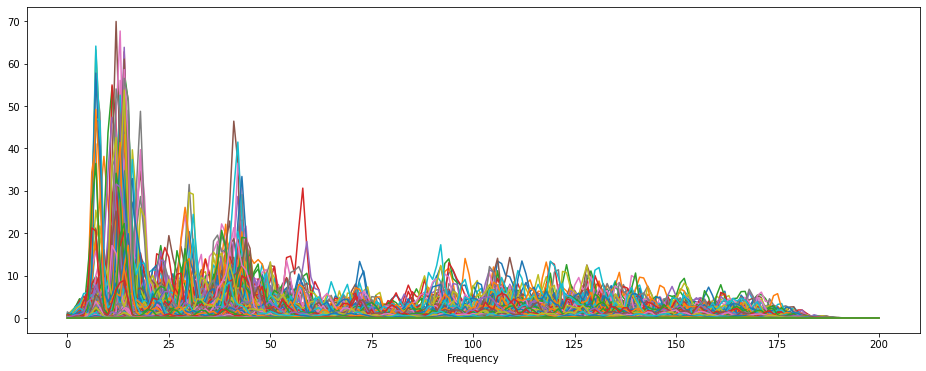

In [23]:
ft_0 = np.abs(librosa.stft(y_0, n_fft=400, hop_length=160))# n_fft, hop_length 변경

print(ft_0.shape)

plt.figure(figsize=(16,6))
plt.plot(ft_0)
plt.xlabel("Frequency")
plt.show()

**양성(1)**

(201, 979)


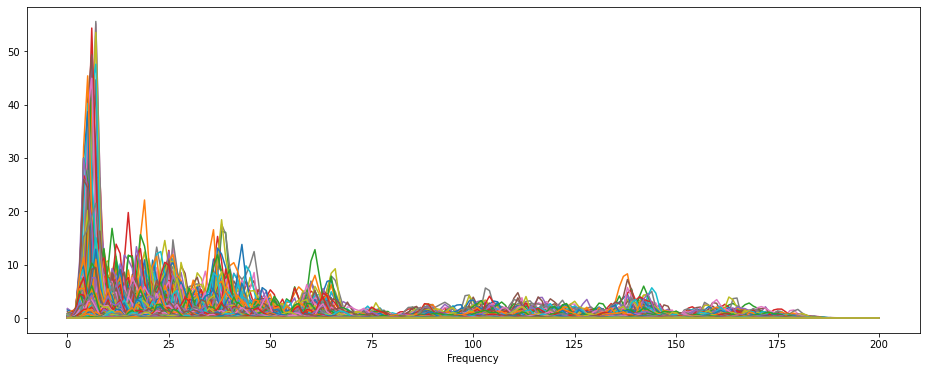

In [47]:
ft_1 = np.abs(librosa.stft(y_1, n_fft=400, hop_length=160))# n_fft, hop_length 변경

print(ft_1.shape)

plt.figure(figsize=(16,6))
plt.plot(ft_1)
plt.xlabel("Frequency")
plt.show()

### Spectrogram  
- 시간에 따른 신호 주파수의 스펙트럼 그래프
- 다른 이름: Sonographs, Voiceprints, Voicegrams

**음성(0)**

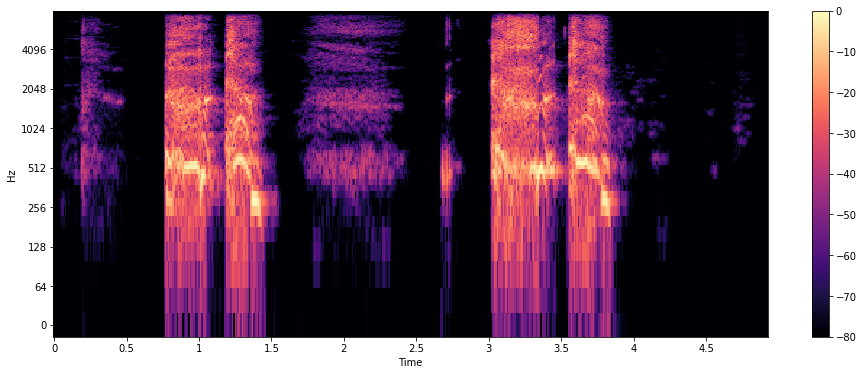

In [25]:
ft_DB_0 = librosa.amplitude_to_db(ft_0, ref=np.max)

plt.figure(figsize=(16,6))
librosa.display.specshow(ft_DB_0, sr=sr_0, hop_length=160, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

**양성(1)**

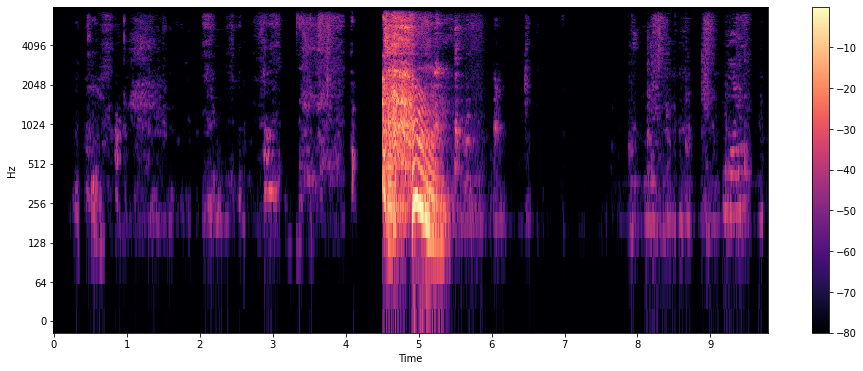

In [26]:
ft_DB_1 = librosa.amplitude_to_db(ft_1, ref=np.max)

plt.figure(figsize=(16,6))
librosa.display.specshow(ft_DB_1, sr=sr_1, hop_length=160, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

### Mel Spectrogram
- 사람이 이해하기 힘든 Spectrogram의 y축을 Mel Scale로 변환한 것(Non-linear transformation)
- Mel Scale: https://newsight.tistory.com/294  
- 간단히 말해 Mel Scale도 log scale 중 하나! 사람이 인지하는 음의 높낮이는 Hz(헤르츠)와 linear(선형) 관계가 아니라 exponential(지수) 관계에 있다고 함, 따라서 log scale을 취해서 값을 normalize하면 사람이 음을 인지하는 기준을 반영한 scale로 변환이 가능한데, 이 변환이 바로 Mel Scale 변환


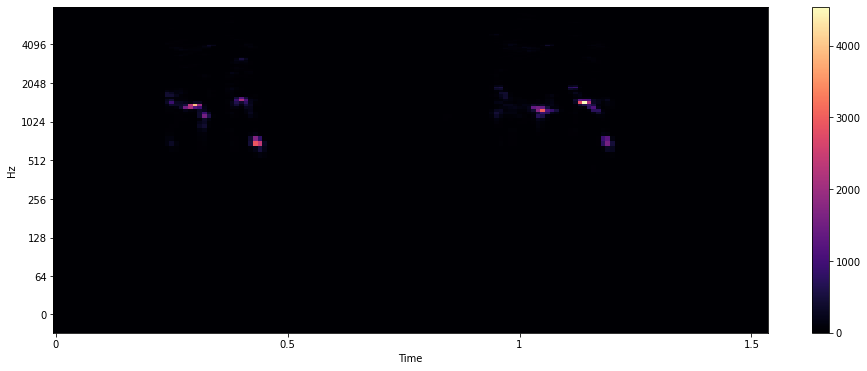

In [27]:
# (참고용)librosa.power_to_db를 하지 않으면 나오는 그래프
mel_0 = librosa.feature.melspectrogram(y=y_0, sr=sr_0)

plt.figure(figsize=(16,6))
librosa.display.specshow(mel_0, sr=sr_0, hop_length=160, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

**음성(0)**

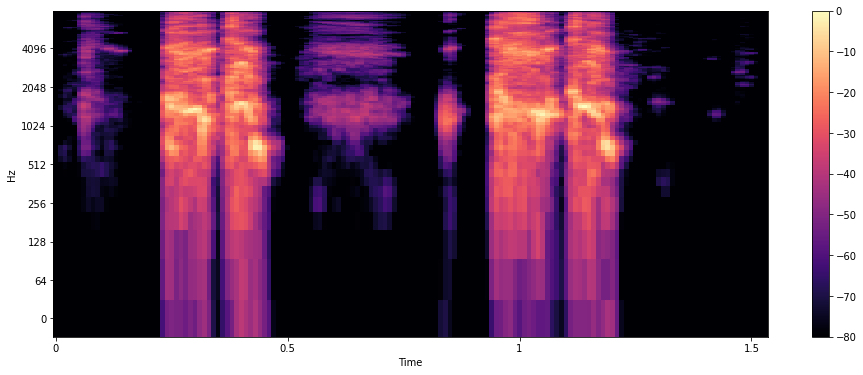

In [28]:
mel_0 = librosa.feature.melspectrogram(y=y_0, sr=sr_0)
mel_DB_0 = librosa.power_to_db(mel_0, ref=np.max)

plt.figure(figsize=(16,6))
librosa.display.specshow(mel_DB_0, sr=sr_0, hop_length=160, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

In [29]:
# 뒤에서 melspectrogram delta 값 때문에 비교차 확인

len(mel_DB_0)

128

**양성(1)**

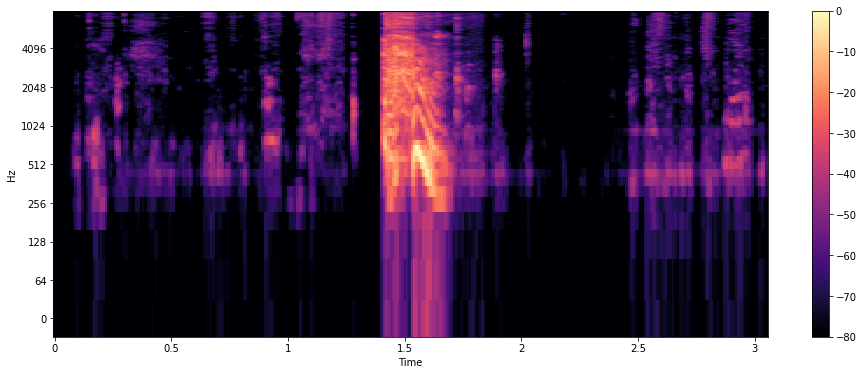

In [30]:
mel_1 = librosa.feature.melspectrogram(y=y_1, sr=sr_1)
mel_DB_1 = librosa.power_to_db(mel_1, ref=np.max)

plt.figure(figsize=(16,6))
librosa.display.specshow(mel_DB_1, sr=sr_1, hop_length=160, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

In [31]:
# 뒤에서 melspectrogram delta 값 때문에 비교차 확인

len(mel_DB_1)

128

**n_mels 파라미터 값을 32, 16으로 설정하여 차이 확인**  
-  n_mels: 적용할 mel filter의 개수를 의미

**음성(0)**

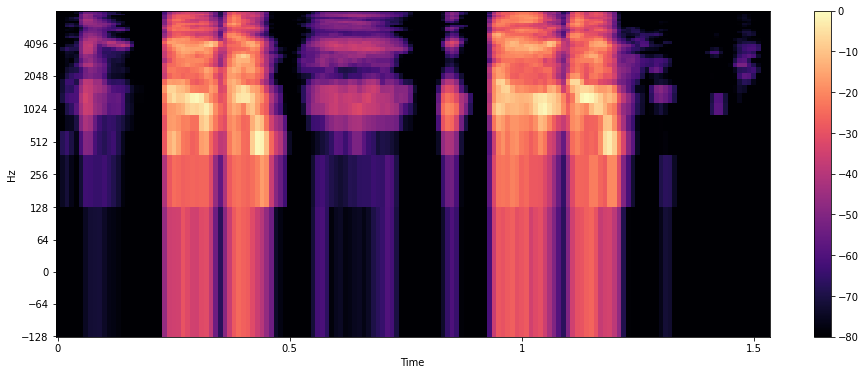

In [33]:
# n_mels = 32 설정

mel_0 = librosa.feature.melspectrogram(y=y_0, sr=sr_0, 
                                       n_mels = 32)
mel_DB_0 = librosa.power_to_db(mel_0, ref=np.max)

plt.figure(figsize=(16,6))
librosa.display.specshow(mel_DB_0, sr=sr_0, hop_length=160, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

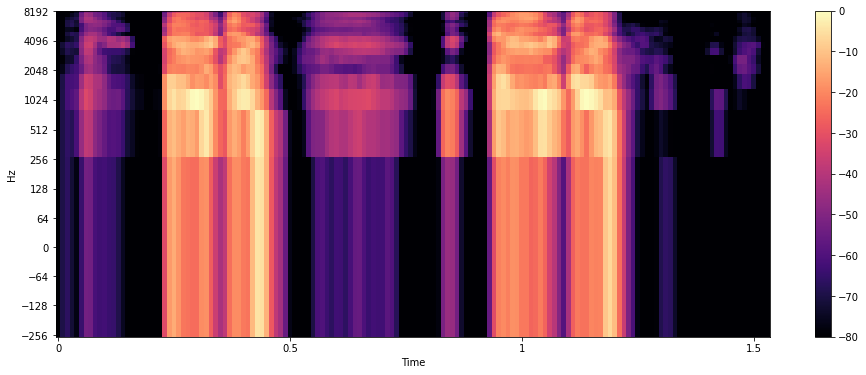

In [34]:
# n_mels = 16(CFG['N_melspectrogram']) 설정

mel_0 = librosa.feature.melspectrogram(y=y_0, sr=sr_0, 
                                       n_mels = 16)
mel_DB_0 = librosa.power_to_db(mel_0, ref=np.max)

plt.figure(figsize=(16,6))
librosa.display.specshow(mel_DB_0, sr=sr_0, hop_length=160, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

**양성(1)**

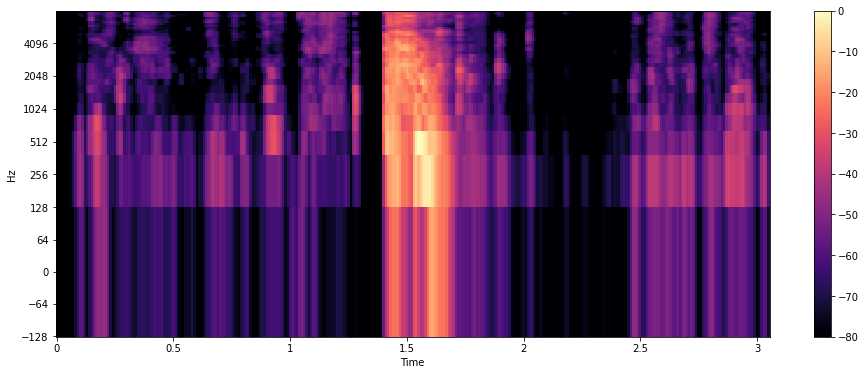

In [35]:
# n_mels = 32 설정

mel_1 = librosa.feature.melspectrogram(y=y_1, sr=sr_1, 
                                       n_mels = 32)
mel_DB_1 = librosa.power_to_db(mel_1, ref=np.max)

plt.figure(figsize=(16,6))
librosa.display.specshow(mel_DB_1, sr=sr_1, hop_length=160, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

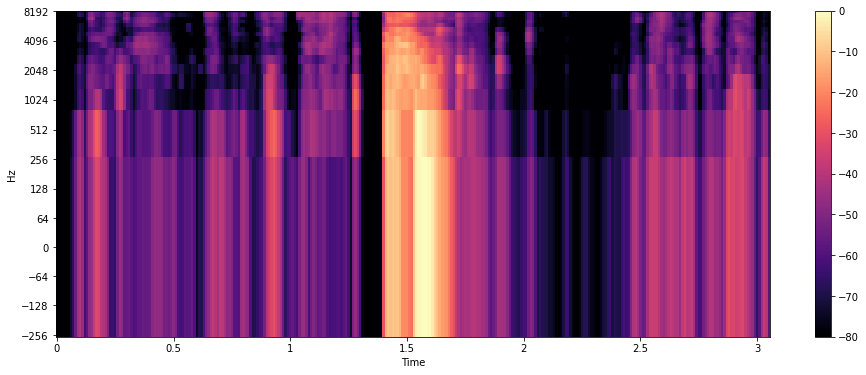

In [36]:
# n_mels = 16(CFG['N_melspectrogram']) 설정

mel_1 = librosa.feature.melspectrogram(y=y_1, sr=sr_1, 
                                       n_mels = 16)
mel_DB_1 = librosa.power_to_db(mel_1, ref=np.max)

plt.figure(figsize=(16,6))
librosa.display.specshow(mel_DB_1, sr=sr_1, hop_length=160, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

n_mels = 16일 때가 좀 더 특징이 두드러지는 것 같아 n_mels=16으로 설정하여 분석함

## 오디오 특성 추출

### Mel Spectrogram의 delta  
mel spectrogram에서 특징을 더 뽑아내는 방법으로는 각 값들의 미분값의 평균으로 구해지는 delta(변화량)가 있음

In [37]:
# 음성 샘플
mel_0 = librosa.feature.melspectrogram(y=y_0, sr=sr_0, 
                                       n_mels = 16)
mel_DB_0 = librosa.power_to_db(mel_0, ref=np.max)

# 양성 샘플
mel_1 = librosa.feature.melspectrogram(y=y_1, sr=sr_1, 
                                       n_mels = 16)
mel_DB_1 = librosa.power_to_db(mel_1, ref=np.max)

**음성(0)**

In [72]:
mel_DB_0.shape

(16, 154)

In [38]:
print(mel_DB_0, '\n', len(mel_DB_0))

[[-80.       -69.84725  -66.64065  ... -80.       -80.       -80.      ]
 [-80.       -69.97721  -66.06764  ... -80.       -80.       -80.      ]
 [-80.       -69.504776 -61.9282   ... -80.       -80.       -80.      ]
 ...
 [-80.       -80.       -74.300385 ... -80.       -80.       -80.      ]
 [-80.       -80.       -79.186745 ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]] 
 16


In [39]:
temp_0 = []
for e in mel_DB_0:
    temp_0.append(np.mean(librosa.feature.delta(e)))
        
print(temp_0, '\n', len(temp_0))

[-0.011382772, -0.008020153, -0.021295918, 0.027118621, 0.070556, 0.0854773, 0.09465106, 0.103528455, 0.09523424, 0.06476058, 0.08285673, 0.038093556, 0.051257107, 0.054237187, 0.057619814, 0.060313694] 
 16


**양성(1)**

In [74]:
mel_DB_1.shape

(16, 306)

In [40]:
print(mel_DB_1, '\n', len(mel_DB_1))

[[-80.       -80.       -80.       ... -37.417233 -40.54798  -58.096184]
 [-80.       -80.       -80.       ... -46.633625 -48.72513  -63.195198]
 [-80.       -80.       -80.       ... -62.994934 -64.55341  -74.28711 ]
 ...
 [-80.       -80.       -80.       ... -74.48679  -77.76881  -80.      ]
 [-80.       -80.       -80.       ... -73.32085  -75.43147  -80.      ]
 [-80.       -80.       -80.       ... -73.86932  -75.48052  -80.      ]] 
 16


In [41]:
y_feature_1 = []
for e in mel_DB_1:
    y_feature_1.append(np.mean(librosa.feature.delta(e)))
        
print(y_feature_1, '\n', len(y_feature_1))

[0.12801997, 0.09078735, 0.008577958, 0.0061520594, 0.03135211, 0.02204865, 0.001578761, 0.0043836357, -0.0030472823, 0.0009335038, -0.007120145, -0.022804372, -0.016449062, -0.02210324, -0.021628898, -0.024851058] 
 16


### Harmonic and Percussive Components
- Harmonic(운율적 소리): 사람의 귀로 구분할 수 없는 특징들(음악의 색깔)  
- Percussive(두드리는 소리): 리듬과 감정을 나타내는 충격파  

hpss: harmonic-percussive source separation

**음성(0)**

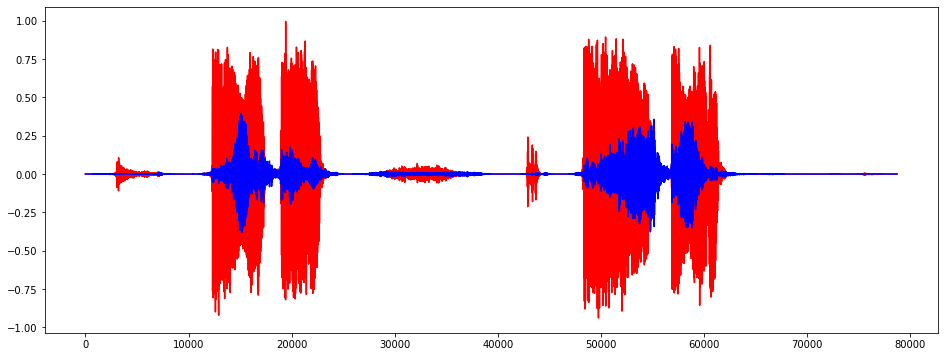

In [42]:
y_harmonic_0, y_percussive_0 = librosa.effects.hpss(y_0)

plt.figure(figsize=(16,6))
plt.plot(y_percussive_0, color='r') # 빨강: Percussive
plt.plot(y_harmonic_0, color='b') # 파랑: Harmonic
plt.show()

**양성(1)**

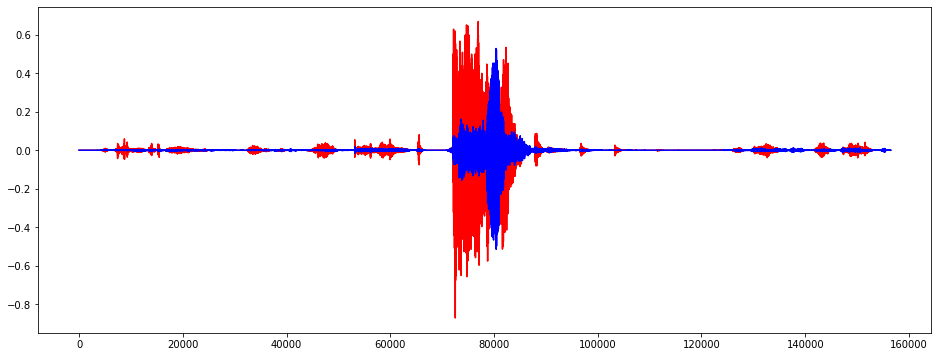

In [43]:
y_harmonic_1, y_percussive_1 = librosa.effects.hpss(y_1)

plt.figure(figsize=(16,6))
plt.plot(y_percussive_1, color='r') # 빨강: Percussive
plt.plot(y_harmonic_1, color='b') # 파랑: Harmonic
plt.show()

위와 같이 하나의 음파를 harmonic과 percussive 2개로 나눠 각각의 특징을 반영하는 feature도 추가하기로 함

# Preprocessing(1)

- feature 1. melspectrogram(n_mels=16)
- feature 2. melspectrogram(n_mels=16)의 델타  
- feature 3. harmonic & percussive의 평균(melspectrogram 활용, n_mels=16)  

wav 데이터로부터 위의 세가지 feature로 특성 추출(feature extraction)

### train feature engineering

In [44]:
# train feature engineering
# Data Folder path
root_folder = './data/'

features = []
log_specgrams_hp = []
f_list1 = []
f_list2 = []
f_list3 = []

# 반복문으로 train의 wav 음성 데이터 불러오기
for uid in tqdm(train_df['id']):
    
    root_path = os.path.join(root_folder, 'train')
    path = os.path.join(root_path, str(uid).zfill(5)+'.wav')
    
    # librosa 패키지를 사용하여 wav 파일 load
    # 'SR' 사용
    y, sr = librosa.load(path, sr=CFG['SR'])
    
    # feature1, feature2
    # librosa 패키지를 사용하여 melspectrogram 추출
    # 'N_melspectrogram' 사용
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=CFG['N_melspectrogram'])
    
    # log scale로 변환
    log_melspectrogram = librosa.power_to_db(S=melspectrogram, ref=1.0)
    
    # feature1: 추출된 log melspectrogram들의 평균을 feature로 사용
    y_feature1 = []
    for e in log_melspectrogram:
        y_feature1.append(np.mean(e))
    f_list1.append(y_feature1)
    
    # feature2: log melspectrogram의 델타값을 feature로 사용
    y_feature2 = []
    for e in log_melspectrogram:
        y_feature2.append(np.mean(librosa.feature.delta(e)))
    f_list2.append(y_feature2)
    
    # feature3
    # librosa.effects.hpss를 사용한 feature 추출
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    melspec_harmonic = librosa.feature.melspectrogram(y_harmonic, n_mels=CFG['N_melspectrogram'])
    melspec_percussive = librosa.feature.melspectrogram(y_percussive, n_mels=CFG['N_melspectrogram'])
    logspec_harmonic = librosa.amplitude_to_db(melspec_harmonic)
    logspec_percussive = librosa.amplitude_to_db(melspec_percussive)
    logspec_hp = np.average([logspec_harmonic, logspec_percussive], axis=0)
    
    y_feature3 = []
    for e in logspec_hp:
        y_feature3.append(np.mean(e))
    f_list3.append(y_feature3)

100%|██████████| 3805/3805 [44:10<00:00,  1.44it/s]


In [45]:
# 기존의 자가진단 정보를 담은 데이터프레임에 추출된 오디오 feature를 추가
f_list1 = pd.DataFrame(f_list1)
f_list2 = pd.DataFrame(f_list2)
f_list3 = pd.DataFrame(f_list3)
# 'N_melspectrogram' 사용
f_list1.columns = ['melspectrogram_1_' + str(x) for x in range(1, CFG['N_melspectrogram']+1)]
f_list2.columns = ['melspectrogram_2_' + str(x) for x in range(1, CFG['N_melspectrogram']+1)]
f_list3.columns = ['melspectrogram_3_' + str(x) for x in range(1, CFG['N_melspectrogram']+1)]

# feature engineering된 train 데이터 생성 후 csv 파일로 저장
melspectrogram_train_df = pd.concat([f_list1, f_list2, f_list3], axis=1)
train_df = pd.concat([train_df, melspectrogram_train_df], axis=1)
train_df.to_csv('./train_melspectrogram_3features.csv', index=False)
print('Done.')

Done.


### test feature engineering

In [48]:
# Data Folder path
root_folder = './data/'

    
features = []
log_specgrams_hp = []
f_list1=[]
f_list2=[]
f_list3=[]

for uid in tqdm(test_df['id']):
    
    root_path = os.path.join(root_folder, 'test')
    path = os.path.join(root_path, str(uid).zfill(5)+'.wav')
    
    # librosa패키지를 사용하여 wav 파일 load
    # 'SR' 사용
    y, sr = librosa.load(path, sr=CFG['SR'])
     
    # feature1, feature2
    # librosa패키지를 사용하여 melspectrogram 추출
    # 'N_melspectrogram' 사용
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=CFG['N_melspectrogram'])

    # log scale로 변환
    log_melspectrogram = librosa.power_to_db(S=melspectrogram, ref=1.0)
    
    # feature1 : 추출된 log melspectrogram들의 평균을 Feature로 사용
    y_feature1 = []
    for e in log_melspectrogram:
        y_feature1.append(np.mean(e))    
    f_list1.append(y_feature1)

    # feature2 : log melspectrogram의 델타값을 Feature로 사용
    y_feature2 = []
    for e in log_melspectrogram:
        y_feature2.append(np.mean(librosa.feature.delta(e)))
    f_list2.append(y_feature2)
    
    # feature3
    # librosa.effects.hpss를 사용한 feature 추출
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    melspec_harmonic = librosa.feature.melspectrogram(y_harmonic, n_mels = CFG['N_melspectrogram'])
    melspec_percussive = librosa.feature.melspectrogram(y_percussive, n_mels = CFG['N_melspectrogram'])
    logspec_harmonic = librosa.amplitude_to_db(melspec_harmonic)
    logspec_percussive = librosa.amplitude_to_db(melspec_percussive)
    logspec_hp = np.average([logspec_harmonic, logspec_percussive], axis=0)

    y_feature3 = []
    for e in logspec_hp:
        y_feature3.append(np.mean(e))
    f_list3.append(y_feature3)

100%|██████████| 5732/5732 [1:08:56<00:00,  1.39it/s]


In [49]:
# 기존의 자가진단 정보를 담은 데이터프레임에 추출된 오디오 Feature를 추가
f_list1 = pd.DataFrame(f_list1)
f_list2 = pd.DataFrame(f_list2)
f_list3 = pd.DataFrame(f_list3)
# 'N_melspectrogram' 사용
f_list1.columns = ['melspectrogram_1_'+str(x) for x in range(1,CFG['N_melspectrogram']+1)]
f_list2.columns = ['melspectrogram_2_'+str(x) for x in range(1,CFG['N_melspectrogram']+1)]
f_list3.columns = ['melspectrogram_3_'+str(x) for x in range(1,CFG['N_melspectrogram']+1)]

# feature engineering된 test 데이터 생성 후 csv 파일로 저장
melspectrogram_test_df = pd.concat([f_list1,f_list2,f_list3], axis=1)
test_df = pd.concat([test_df, melspectrogram_test_df], axis=1)
test_df.to_csv('./test_melspectrogram_3features.csv', index=False)
print('Done.')

Done.


In [80]:
# 1차 전처리 확인-train

temp1 = pd.read_csv('./train_melspectrogram_3features.csv')
temp1.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19,melspectrogram_1_1,melspectrogram_1_2,melspectrogram_1_3,melspectrogram_1_4,...,melspectrogram_3_7,melspectrogram_3_8,melspectrogram_3_9,melspectrogram_3_10,melspectrogram_3_11,melspectrogram_3_12,melspectrogram_3_13,melspectrogram_3_14,melspectrogram_3_15,melspectrogram_3_16
0,1,24,female,0,1,0,-26.522932,-17.946022,-13.602118,-18.125856,...,-24.394270,-23.691849,-21.333744,-23.385555,-27.368216,-27.609705,-27.638462,-27.658413,-28.357336,-29.348507
1,2,51,male,0,0,0,-16.887941,-19.999722,-20.116838,-21.754314,...,-36.636837,-35.777330,-35.417984,-38.836086,-42.778370,-43.114570,-43.727283,-42.589100,-40.481396,-40.492310
2,3,22,male,0,0,0,-37.706238,-36.054585,-34.213425,-36.062000,...,-44.112880,-44.407160,-47.210407,-49.595478,-51.025000,-50.641624,-51.263054,-52.722656,-52.920483,-52.957800
3,4,29,female,1,0,0,-29.440800,-26.680387,-24.942842,-27.226229,...,-34.815334,-36.882652,-36.698635,-35.982418,-37.526077,-35.692738,-35.541460,-37.513500,-37.747340,-37.726517
4,5,23,male,0,0,0,-47.600555,-48.077522,-49.044025,-48.684902,...,-53.074440,-52.052475,-51.425880,-51.920260,-52.641006,-52.996320,-52.499798,-52.549644,-53.039238,-53.925083


In [81]:
# 1차 전처리 확인-test

temp2 = pd.read_csv('./test_melspectrogram_3features.csv')
temp2.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain,melspectrogram_1_1,melspectrogram_1_2,melspectrogram_1_3,melspectrogram_1_4,melspectrogram_1_5,...,melspectrogram_3_7,melspectrogram_3_8,melspectrogram_3_9,melspectrogram_3_10,melspectrogram_3_11,melspectrogram_3_12,melspectrogram_3_13,melspectrogram_3_14,melspectrogram_3_15,melspectrogram_3_16
0,3806,48,female,1,0,-55.395840,-55.154470,-55.376923,-56.132793,-56.835540,...,-67.491750,-67.333070,-67.359410,-67.457010,-67.568830,-67.751360,-67.763850,-67.847440,-67.774950,-67.831230
1,3807,24,female,0,0,-47.435764,-47.310350,-46.436256,-46.435380,-47.319042,...,-61.408546,-61.136260,-61.780197,-62.523820,-63.763786,-63.486748,-63.054950,-63.318565,-63.535156,-63.806164
2,3808,29,male,0,0,-93.704690,-92.168630,-92.892204,-92.441820,-92.723564,...,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
3,3809,39,female,0,0,-28.627369,-27.526735,-29.803757,-32.324505,-35.387024,...,-29.664099,-29.125324,-28.078190,-28.915506,-29.930180,-28.908342,-29.658663,-30.153528,-29.996970,-30.340740
4,3810,34,male,0,0,-30.801222,-31.130835,-31.803260,-33.741710,-30.804407,...,-34.965900,-38.938843,-41.708454,-43.900280,-43.292070,-44.901436,-43.455326,-45.556120,-46.153183,-46.345192


# Preprocessing(2)

Preprocessing(1)은 오디오 데이터로부터 특성을 추출하기 위한 단계였다면  
Preprocessing(2)는 모델에 입력하기 위한 최종 형태 데이터를 만드는 단계  

In [50]:
# wav 데이터의 Melspectrogram Feature와 csv 파일 정보를 합친 학습데이터 로드
train_df = pd.read_csv('./train_melspectrogram_3features.csv')

# 학습데이터를 모델의 input으로 들어갈 x와 label로 사용할 y로 분할
train_x = train_df.drop(columns=['id', 'covid19'])
train_y = train_df['covid19']

In [51]:
# 학습데이터로부터 fit된 one-hot encoder(ohe)를 받아 transform 시켜주는 함수
def onehot_encoding(ohe, x):
    encoded = ohe.transform(x['gender'].values.reshape(-1,1))
    encoded_df = pd.DataFrame(encoded, columns=ohe.categories_[0])
    x = pd.concat([x.drop(columns=['gender']), encoded_df], axis=1)
    return x

In [52]:
# 'gender' column의 경우 추가 전처리가 필요 -> OneHotEncoder 적용
ohe = OneHotEncoder(sparse=False)
ohe.fit(train_x['gender'].values.reshape(-1,1))
train_x = onehot_encoding(ohe, train_x)

In [53]:
train_x

,age,respiratory_condition,fever_or_muscle_pain,melspectrogram_1_1,melspectrogram_1_2,melspectrogram_1_3,melspectrogram_1_4,melspectrogram_1_5,melspectrogram_1_6,melspectrogram_1_7,...,melspectrogram_3_10,melspectrogram_3_11,melspectrogram_3_12,melspectrogram_3_13,melspectrogram_3_14,melspectrogram_3_15,melspectrogram_3_16,female,male,other
0,24,0,1,-26.522932,-17.946022,-13.602118,-18.125856,-24.042326,-23.690060,-22.134506,...,-23.385555,-27.368216,-27.609705,-27.638462,-27.658413,-28.357336,-29.348507,1.0,0.0,0.0
1,51,0,0,-16.887941,-19.999722,-20.116838,-21.754314,-24.882048,-26.963436,-24.999727,...,-38.836086,-42.778370,-43.114570,-43.727283,-42.589100,-40.481396,-40.492310,0.0,1.0,0.0
2,22,0,0,-37.706238,-36.054585,-34.213425,-36.062000,-37.285890,-36.566400,-36.136745,...,-49.595478,-51.025000,-50.641624,-51.263054,-52.722656,-52.920483,-52.957800,0.0,1.0,0.0
3,29,1,0,-29.440800,-26.680387,-24.942842,-27.226229,-28.904953,-32.455334,-34.156006,...,-35.982418,-37.526077,-35.692738,-35.541460,-37.513500,-37.747340,-37.726517,1.0,0.0,0.0
4,23,0,0,-47.600555,-48.077522,-49.044025,-48.684902,-48.446503,-51.080124,-50.555874,...,-51.920260,-52.641006,-52.996320,-52.499798,-52.549644,-53.039238,-53.925083,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800,53,0,0,-23.556318,-15.893322,-17.035818,-23.162060,-25.938965,-25.779774,-25.837380,...,-26.699545,-26.806545,-30.645788,-33.582535,-34.704597,-34.822230,-34.755142,0.0,1.0,0.0
3801,25,0,0,-18.580786,-14.863310,-14.404734,-21.268797,-25.634426,-28.513365,-28.759747,...,-57.071777,-58.394684,-57.745430,-56.637966,-58.809600,-60.271713,-60.292206,0.0,1.0,0.0
3802,26,0,0,-8.866052,-16.635527,-27.720947,-29.630096,-30.591015,-31.231684,-31.606777,...,-29.489532,-30.813726,-30.599379,-30.986303,-31.362831,-31.232924,-31.443905,1.0,0.0,0.0
3803,27,0,0,-4.608374,-1.341979,-1.630033,-2.866049,-5.834198,-8.299120,-6.481061,...,-28.601734,-29.925383,-28.045181,-29.462437,-32.164173,-31.285854,-33.261120,1.0,0.0,0.0


# Modeling

모델은 DNN(Deep Neural Network, 딥러닝 신경망)을 사용

### 모델 정의

In [54]:
def get_model():
    model = models.Sequential()
    
    model.add(layers.Dense(512, activation='relu', input_shape=(train_x.shape[1],)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

In [55]:
# 모델구조 요약
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               28160     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                6

### 모델 학습

In [56]:
# 배치크기, 조기종료 patience 설정
my_batch_size = 64
early_stopping_patience = 10

# 모델 중간저장 및 조기종료 조건이 포함된 callback 설정
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='./model/model_{epoch:02d}.h5',
                                      save_freq='epoch',
                                      save_best_only=True,
                                      period=10),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                     patience=early_stopping_patience,
                                     restore_best_weights=True)
]

In [57]:
# 모델 학습
history = model.fit(train_x, train_y, epochs = 100, batch_size = my_batch_size, 
                    callbacks = my_callbacks, validation_split=0.2)

Epoch 1/100
48/48 [==============================] - 4s 47ms/step - loss: 0.6743 - accuracy: 0.8906 - val_loss: 0.3409 - val_accuracy: 0.9080
Epoch 2/100
48/48 [==============================] - 2s 41ms/step - loss: 0.3138 - accuracy: 0.9225 - val_loss: 0.3256 - val_accuracy: 0.9080
Epoch 3/100
48/48 [==============================] - 1s 25ms/step - loss: 0.2980 - accuracy: 0.9225 - val_loss: 0.3212 - val_accuracy: 0.9080
Epoch 4/100
48/48 [==============================] - 2s 41ms/step - loss: 0.3007 - accuracy: 0.9215 - val_loss: 0.3177 - val_accuracy: 0.9080
Epoch 5/100
48/48 [==============================] - 1s 22ms/step - loss: 0.2908 - accuracy: 0.9225 - val_loss: 0.3250 - val_accuracy: 0.9080
Epoch 6/100
48/48 [==============================] - 2s 39ms/step - loss: 0.2892 - accuracy: 0.9225 - val_loss: 0.3109 - val_accuracy: 0.9080
Epoch 7/100
48/48 [==============================] - 1s 16ms/step - loss: 0.2834 - accuracy: 0.9221 - val_loss: 0.3137 - val_accuracy: 0.9080
Epoch 

### loss, accuracy 시각화

In [58]:
test_loss, test_acc = model.evaluate(train_x, train_y)

119/119 [==============================] - 2s 20ms/step - loss: 0.2557 - accuracy: 0.9196


In [59]:
def history_loss_acc(history, name):
    # history에 있는 모든 데이터 나열
    print(history.history.keys())
    
    # history의 loss 기록 요약
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss_' + name)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # history의 accuracy 기록 요약
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy_' + name)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


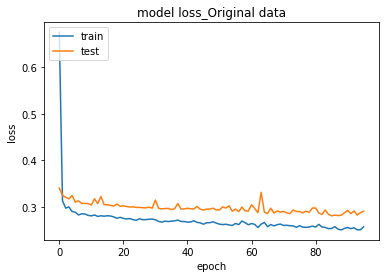

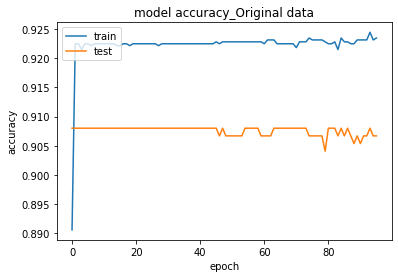

In [60]:
# history의 accuracy, loss 시각화
history_loss_acc(history, 'Original data')

### 모델 예측

위에서 train data를 전처리한 과정과 동일하게 test data도 전처리

In [61]:
test_x = pd.read_csv('./test_melspectrogram_3features.csv')
test_x = test_x.drop(columns=['id'])

# train data로만 학습된 ohe(원-핫 인코더) 사용(Data Leakage에 유의)
test_x = onehot_encoding(ohe, test_x)

In [62]:
# 모델 예측
preds = model.predict(test_x)

In [63]:
preds

array([[0.9085529 , 0.0914471 ],
       [0.9055145 , 0.09448558],
       [0.9658916 , 0.03410844],
       ...,
       [0.91082007, 0.08917996],
       [0.92582124, 0.07417876],
       [0.73446786, 0.26553217]], dtype=float32)

threshold를 설정하여 확률을 0/1로 분류  
threshold를 몇으로 설정하냐에 따라 예측 결과 달라짐

In [82]:
# 현재 threshold: 0.84
pred_thr = pd.DataFrame(np.where((model.predict(test_x) > 0.84), 0, 1))
pred_thr

,0,1
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
5727,0,1
5728,0,1
5729,0,1
5730,0,1


In [83]:
pred_thr = pd.DataFrame(pred_thr.iloc[:, 0])
pred_thr

,0
0,0
1,0
2,0
3,0
4,0
...,...
5727,0
5728,0
5729,0
5730,0


In [66]:
pred_thr.value_counts() # thr=0.85

0    5189
1     543
dtype: int64

In [84]:
pred_thr.value_counts() # thr=0.84

0    5285
1     447
dtype: int64

# Result

### 예측 결과물 submit

In [85]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.head()

,id,covid19
0,3806,-1
1,3807,-1
2,3808,-1
3,3809,-1
4,3810,-1


In [86]:
submit['covid19'] = pred_thr
submit.head()

,id,covid19
0,3806,0
1,3807,0
2,3808,0
3,3809,0
4,3810,0


In [87]:
submit.to_csv('./predictions/best_dnn_prediction.csv', index=False)

# END